In [2]:
import pandas as pd 
import numpy as np 

In [3]:
df = pd.read_csv("ARP_Returns.csv")

In [4]:
list(df.columns[1:])

['Equity Momentum',
 'Equity Low Beta',
 'Equity Quality',
 'Commodity Carry',
 'Commodity Curve',
 'Credit Curve',
 'Credit Carry',
 'FX Carry',
 'FX Value',
 'Interest Rate Spread',
 'Interest Rate Curve',
 'Equity Trend',
 'FX Trend',
 'Commodity Trend',
 'Interest Rate Trend',
 'Commodity Volatility Carry',
 'Interest Rate Volatility Carry',
 'Equity Volatility Carry',
 'COT',
 'Merger Arb']

In [5]:
def cal_return(df):
    df_norm = pd.DataFrame()
    df_return = pd.DataFrame()
    df_return['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df_norm['Date'] = df_return['Date']
    strategy_list = list(df.columns[1:])
    for strategy in strategy_list:
        cleaned_name = strategy.lower().replace(' ', '_')
        df_norm[cleaned_name] = df[strategy]/df[strategy].iloc[0]
        df_return[cleaned_name] = df_norm[cleaned_name].diff()
    return df_norm, df_return
df_norm, df_return = cal_return(df)

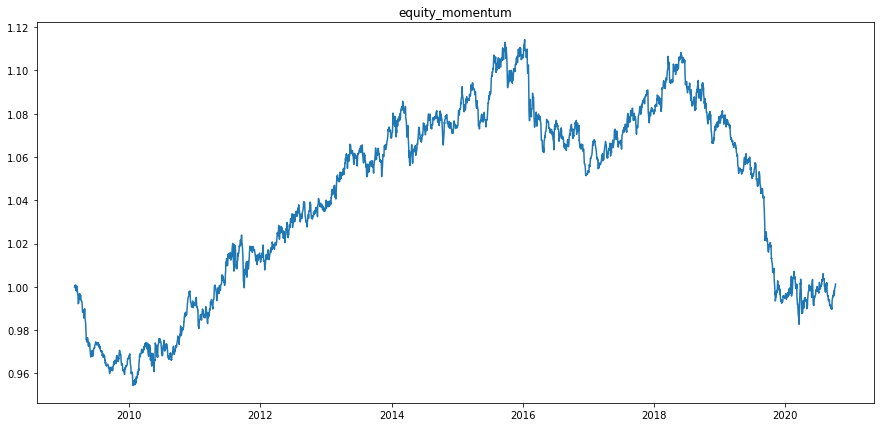

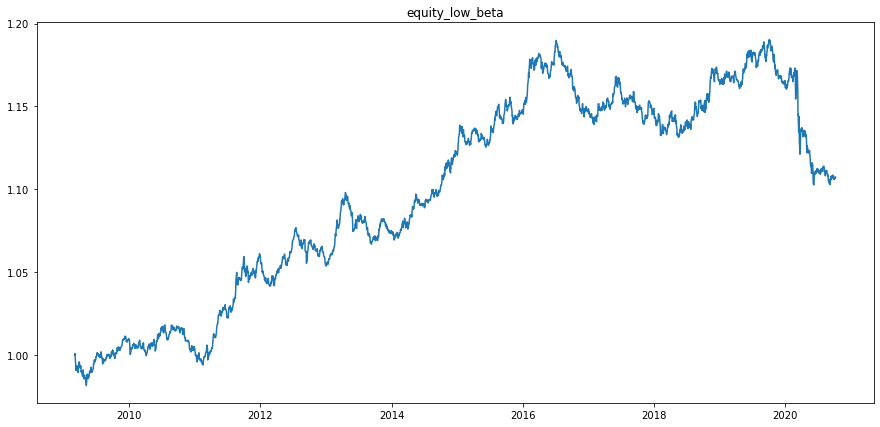

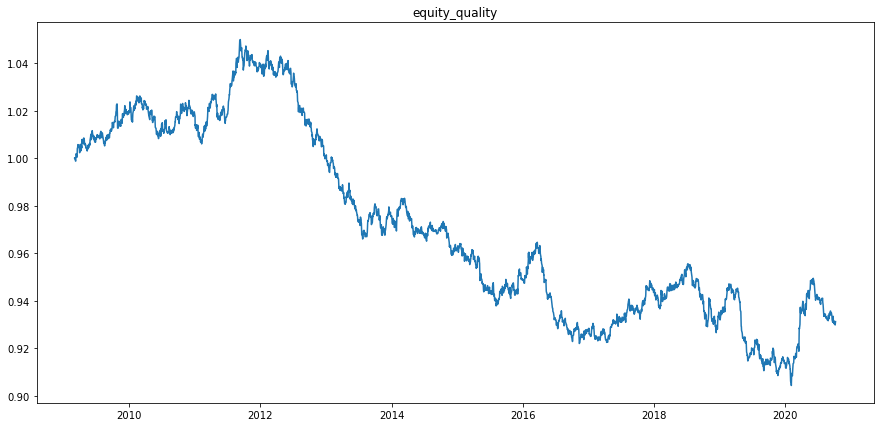

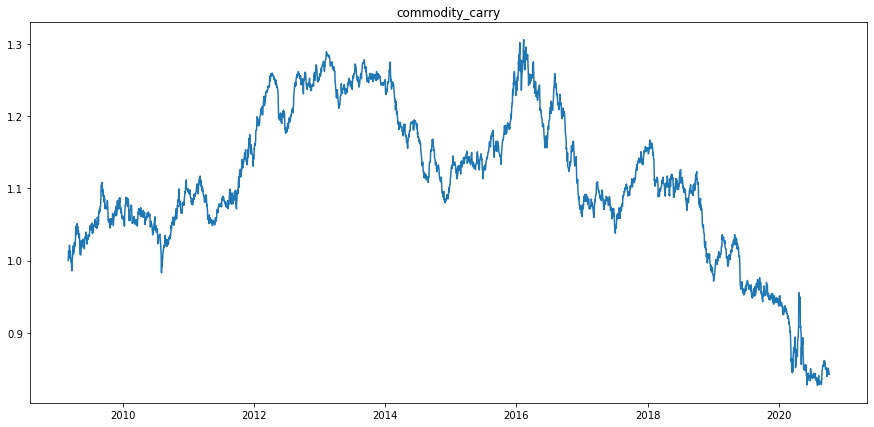

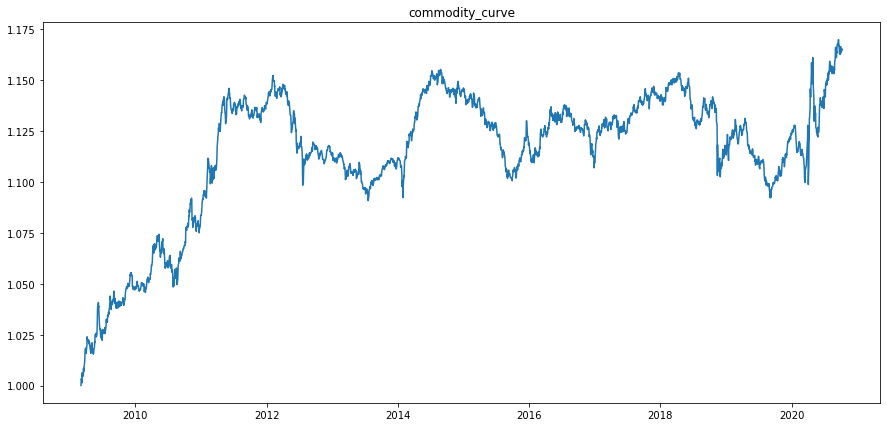

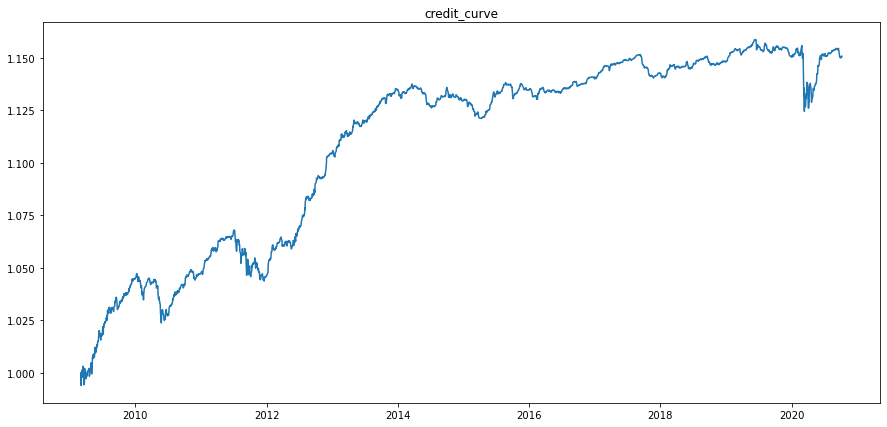

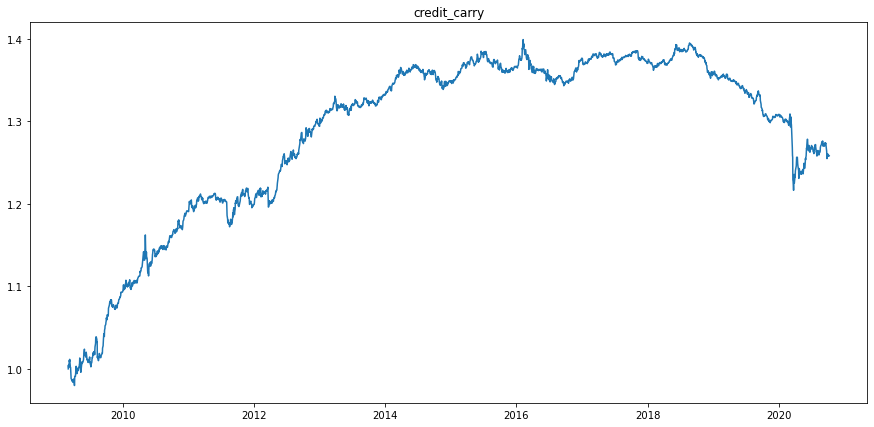

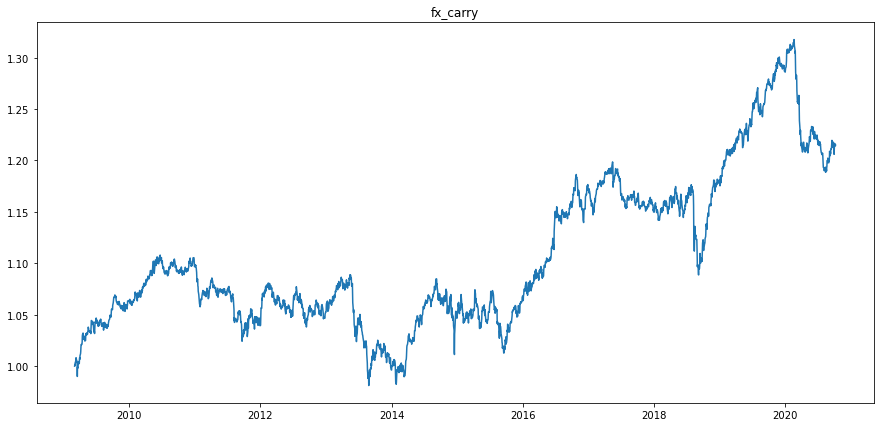

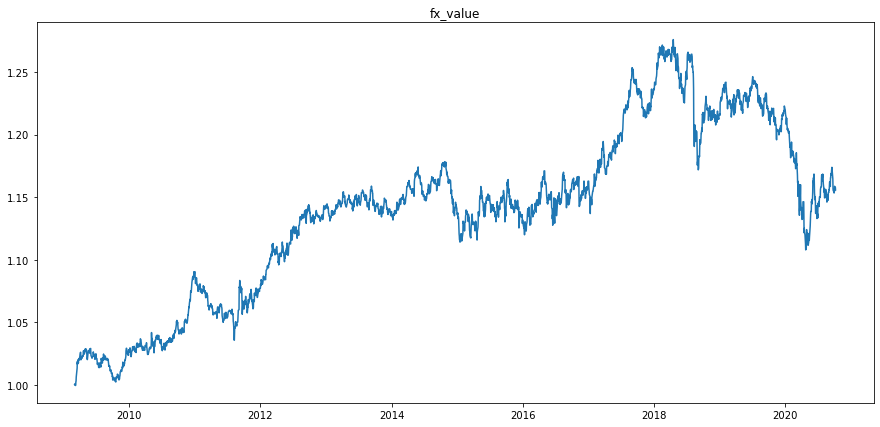

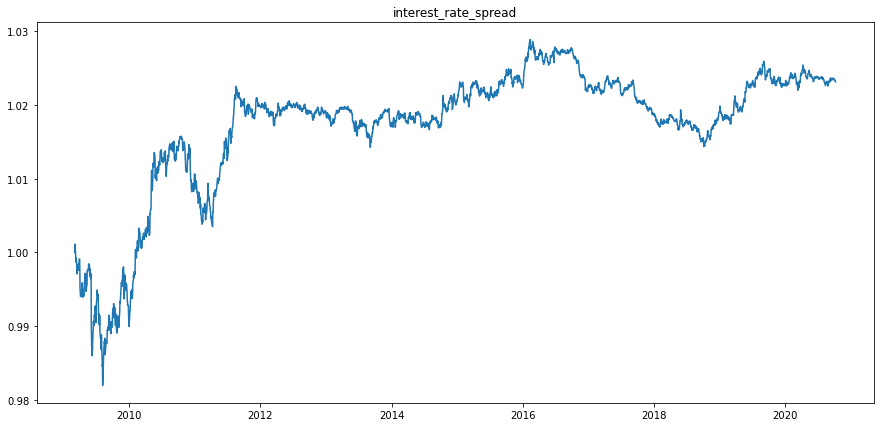

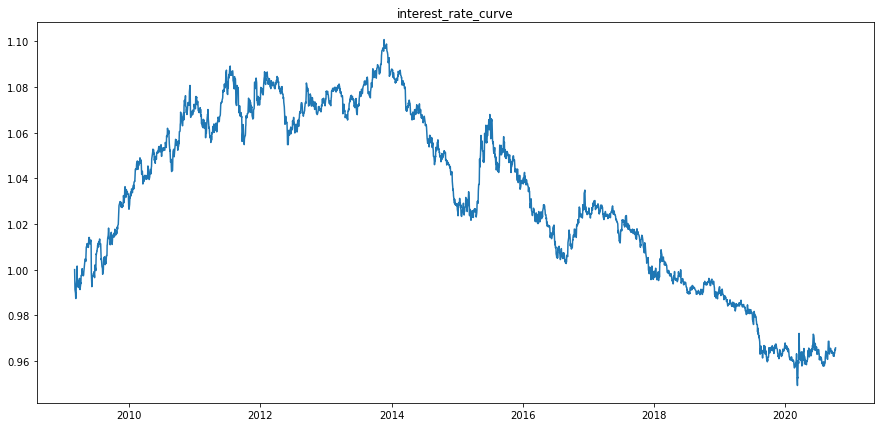

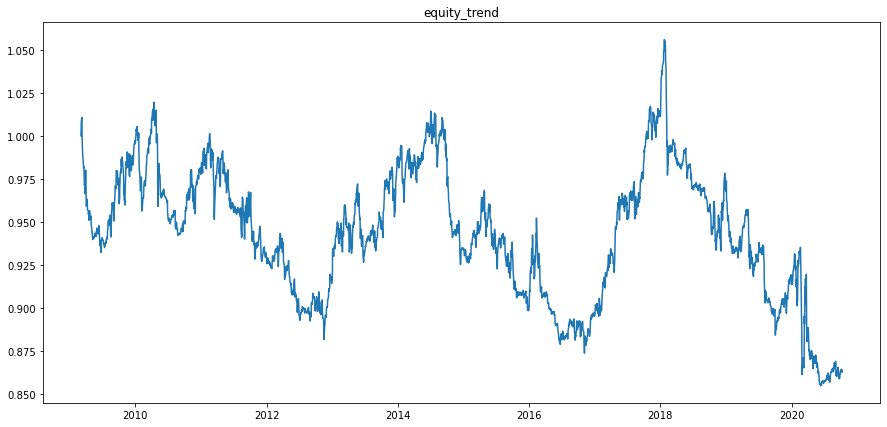

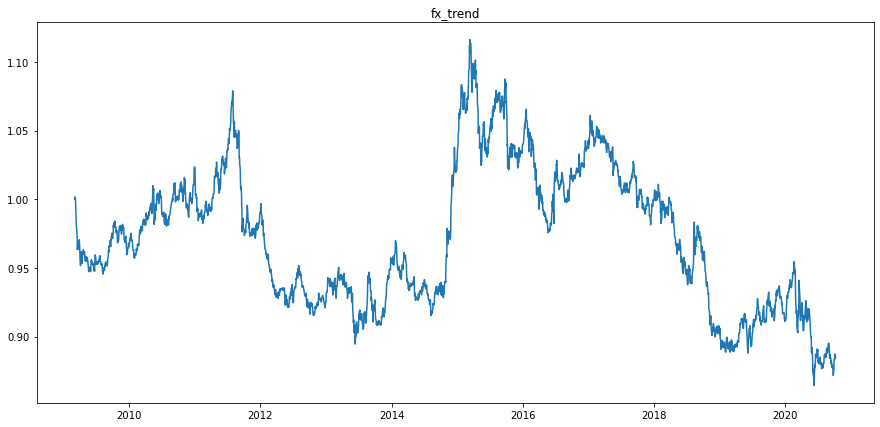

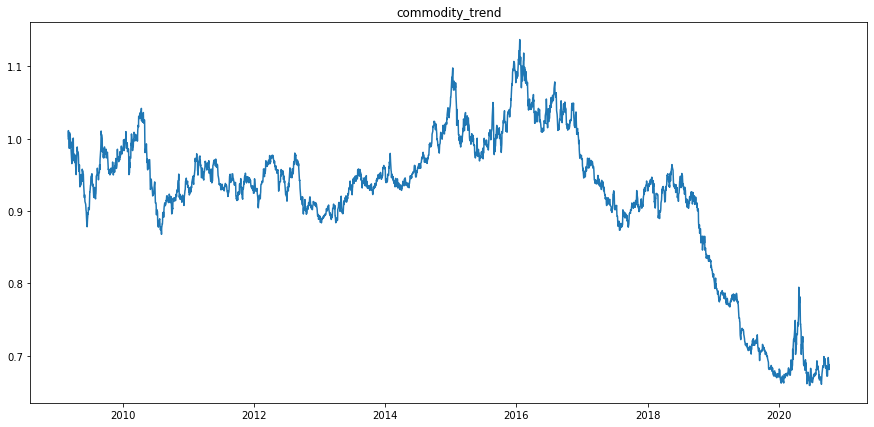

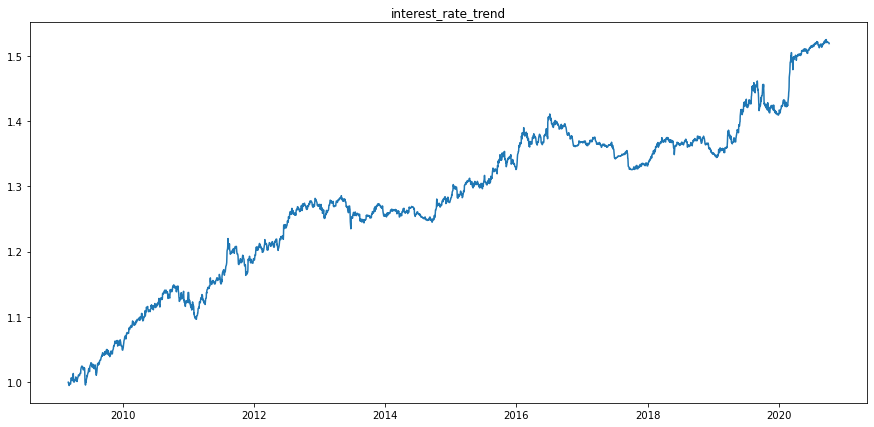

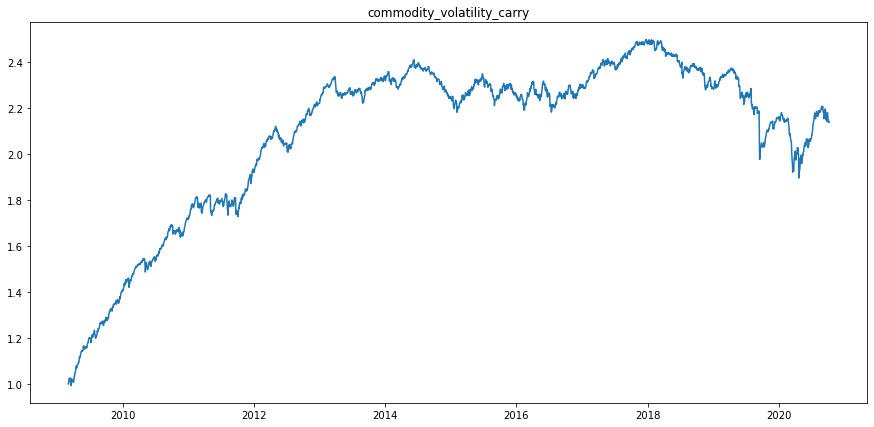

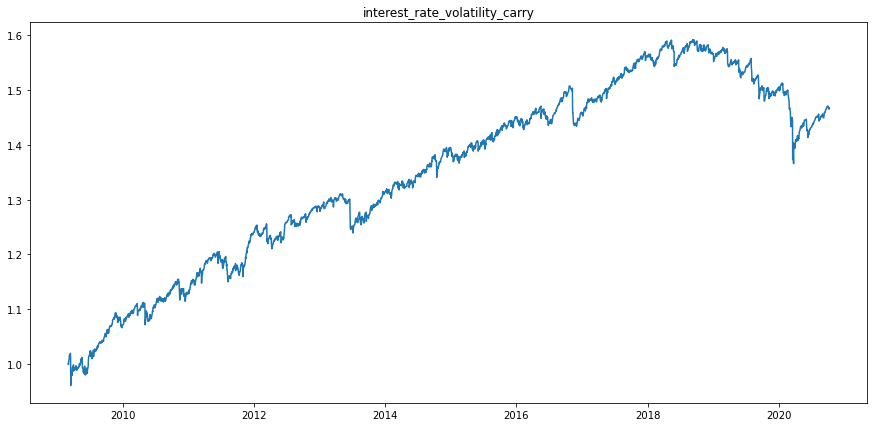

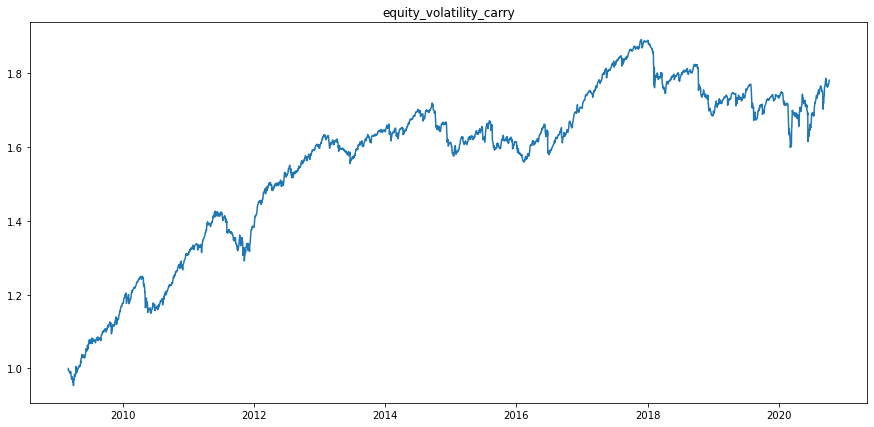

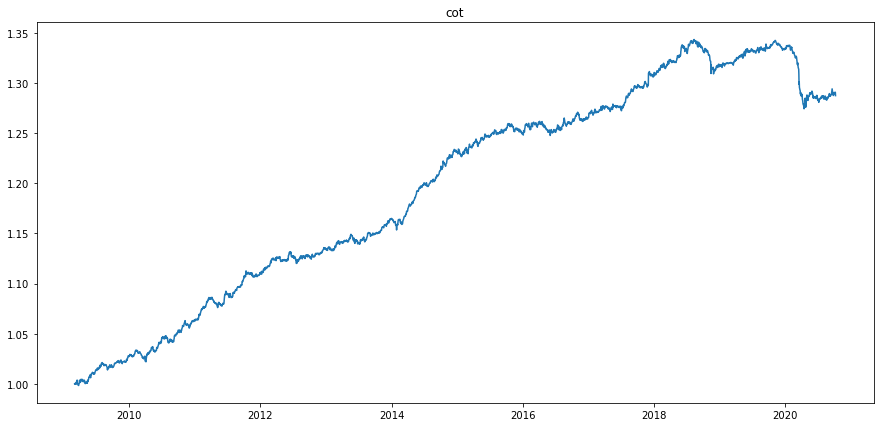

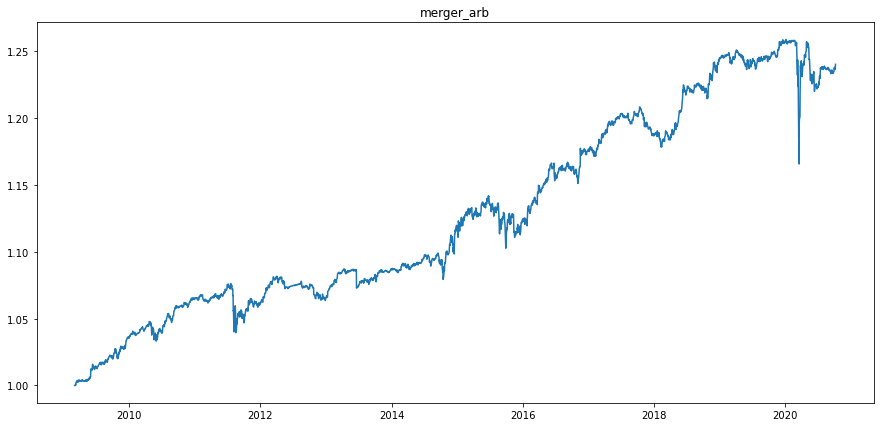

In [6]:
# print each strategy performance
import matplotlib.pyplot as plt 
for strategy in df_norm.columns[1:]:
    plt.figure(figsize=(15,7))
    plt.plot(df_norm['Date'], df_norm[strategy])
    plt.title(strategy)
    

In [54]:
from scipy.optimize import minimize 
# minimize negative sharpe ratio 
num_strategies = len(df_return.columns) - 1
init_guess = np.array(np.random.random(num_strategies))
init_guess /= np.sum(initial_weights)

In [59]:
def get_stats(weights):
    weights = np.array(weights)
    ret = np.sum(df_return.mean() * weights) * 252 
    vol = np.sqrt(np.dot(weights.T, np.dot(df_return.cov() * 252, weights)))
    sharpe_ratio = ret/vol 
    return [ret, vol, sharpe_ratio]

def neg_sharpe(weights):
    return get_stats(weights)[2] * (-1)

def check_sum(weights):
    return np.sum(weights) - 1

In [60]:
# create constraint variable 
cons = ({'type': 'eq', 'fun': check_sum})
bounds = tuple([(0,1) for i in range(num_strategies)])
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [61]:
opt_results

     fun: -2.284236507347833
     jac: array([ 6.85006410e-01,  7.44193792e-04,  4.82164264e-01,  3.03876603e+00,
       -2.71201134e-04, -1.35651231e-03,  7.28487968e-04, -3.79055738e-04,
        1.91245168e-01,  9.69990194e-02,  6.27835453e-01,  1.40848714e+00,
        1.29914385e+00,  1.78577319e+00,  8.17805529e-04,  3.28081846e-03,
       -2.62051821e-03,  5.73244691e-03, -1.78813934e-06, -5.41806221e-05])
 message: 'Optimization terminated successfully'
    nfev: 502
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([3.71375533e-16, 4.85383096e-02, 0.00000000e+00, 0.00000000e+00,
       3.77941035e-02, 2.87365295e-01, 6.82187990e-02, 2.45497994e-02,
       2.74208018e-16, 0.00000000e+00, 0.00000000e+00, 7.12026600e-16,
       7.08329072e-16, 5.09158300e-16, 1.32163656e-01, 1.37374936e-02,
       5.24058859e-03, 3.23588030e-02, 3.18669614e-01, 3.13635379e-02])

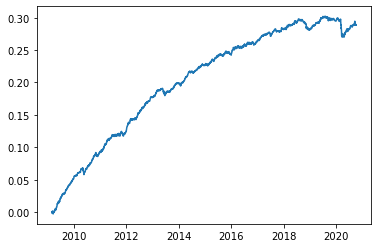

In [74]:
df_portfolio = df_return[df_return.columns[1:]] * opt_results.x
plt.plot(df_return['Date'], df_portfolio.sum(axis=1).cumsum())